In [11]:
#all Python code
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import torch
import time
from timeit import default_timer as timer
from multiprocessing import Pool, cpu_count
from io import open
from datetime import datetime

class PolynomialRegressionModel:
  def __init__(self):
      self.X=[]
      self.Y=[]
      self.dataset=[]

  def equation(self,x,sigma2):
      """This function return the Y values of equation y=np.cos(2*np.pi*x)+z."""
      normal_dist = torch.distributions.normal.Normal(0, sigma2)
      z=normal_dist.sample([1]).unsqueeze(1)[0]
      y=np.cos(2*np.pi*x)+z
      return y

  def getLinearDataset(self,N,a0=1,a1=2.5,sigma2=3):
    """This function was done only to test the regressions with other kind of data."""
    X=[]
    Y=[]
    for i in range(N):
      normal_dist = torch.distributions.normal.Normal(0, sigma2)
      z=normal_dist.sample([1]).unsqueeze(1)[0]
      x=random.uniform(-10, 10)
      X.append(x)
      Y.append(x*a1+a0+z)
    data = pd.DataFrame(data= np.c_[X, Y])
    X = data.iloc[:, 0]
    Y = data.iloc[:, 1]
    return X,Y

  def getData(self,N,sigma2):
    """Question A"""
    X=[]
    Y=[]
    for i in range(N):
      x=random.uniform(0, 1)
      X.append(x)
      Y.append(self.equation(x,sigma2))
    data = pd.DataFrame(data= np.c_[X, Y])
    X = data.iloc[:, 0]
    Y = data.iloc[:, 1]
    return (X,Y)

  def polynomial(self,X,polynomialCoefficients, polynomialDegree):
    """this function return the values Y of a Polynomial equation with input X"""
    Y_pred=pd.DataFrame(data= np.c_[[0]*len(X)]).iloc[:, 0]
    for d in range(polynomialDegree+1):
      Y_pred=Y_pred+polynomialCoefficients[d]*X**d
    return Y_pred

  def getMSE(self,dataset,polynomialCoefficients, polynomialDegree):
    """Question B"""
    X=dataset[0]
    Y=dataset[1]
    Y_pred=pd.DataFrame(data=np.c_[[0]*len(Y)]).iloc[:, 0]
    for d in range(polynomialDegree+1):
      Y_pred=Y_pred+polynomialCoefficients[d]*X**d
    error=Y-Y_pred
    mse=np.mean(error**2)
    return mse


  def fitData(self, dataset, sigma2, polynomialDegree, lambdaR,regularized,optimizationMethod="GD",epochs=5000,datasetType="Non-Linear"):
    """Question C"""
    polynomialCoefficientsEstimated= np.random.normal(size=(polynomialDegree+1)) #initialaze the all coefficients to be estimated
    X_train=dataset[0]
    Y_train=dataset[1]
    n=len(X_train)
    L=0.1 #learning rate
    dataTraceEin=[[],[],[]]
    #GD to find the best polynomial Coefficients
    for i in range(epochs):
      Y_pred=self.polynomial(X_train, polynomialCoefficientsEstimated, polynomialDegree)
      error= Y_train-Y_pred
      Jacobian=[]
      for d in range(polynomialDegree+1):
        if regularized:
          Jacobian.append((-2.0/n)*sum((error)*(X_train**d)) + lambdaR*2*polynomialCoefficientsEstimated[d])     #compute the Jacobian of Loss function regularized
        else:
          Jacobian.append((-2.0/n)*sum((error)*(X_train**d))) #compute the Jacobian of Loss function
        polynomialCoefficientsEstimated[d] = polynomialCoefficientsEstimated[d] - L*Jacobian[d] #update the polynomial Coefficients
      if 0==i%1000:
        print("epoch:",i)

    Ein=self.getMSE(dataset,polynomialCoefficientsEstimated, polynomialDegree)
    if datasetType=="Non-Linear":
      testDataset=self.getData(n,sigma2)
    else:
      testDataset=self.getLinearDataset(n,sigma2=sigma2) #only to test the code with other dataset type
    Eout=self.getMSE(testDataset,polynomialCoefficientsEstimated, polynomialDegree)

    return polynomialCoefficientsEstimated,Ein,Eout



  def experiment(self, N, sigma2, polynomialDegree, lambdaR=0.0, regularized=False):
    """Question D"""
    M=20 #trials
    PolynomialCoefficientsEstimatedAveraged=np.zeros(polynomialDegree+1)
    EinAveraged=0
    EoutAveraged=0

    start = timer()
    print(f'starting computations on {cpu_count()} cores')

    values=list(())
    for i in range(M):
      values.append((self.getData(N,sigma2), sigma2,polynomialDegree,lambdaR,regularized))
    values=tuple(values)
    with Pool() as pool:
        allResults = pool.starmap(self.fitData, values)

    for result in allResults:
      PolynomialCoefficientsEstimatedAveraged = PolynomialCoefficientsEstimatedAveraged + result[0]
      EinAveraged = EinAveraged + result[1]
      EoutAveraged = EoutAveraged + result[2]

    PolynomialCoefficientsEstimatedAveraged = PolynomialCoefficientsEstimatedAveraged/float(M)
    EinAveraged = EinAveraged/float(M)
    EoutAveraged = EoutAveraged/float(M)

    largeDataset=self.getData(1000,sigma2)
    Ebias=self.getMSE(largeDataset,PolynomialCoefficientsEstimatedAveraged, polynomialDegree) #bias

    end = timer()
    print(f'elapsed time: {end - start}')
    #The question require to function outputs Ein,Eout and Ebias, but I am return the Polynomial Coefficients Estimated Averaged to save them to analysis and plots.
    return EinAveraged,EoutAveraged,Ebias,PolynomialCoefficientsEstimatedAveraged


  def saveExperiment(self,filename, N, sigma2, polynomialDegree, lambdaR, regularized ,data):
    """
    This function create a csv file and save all results of the experiment.
    the header of csv will be N, sigma2, polynomialDegree, lambdaR, regularized,EinAveraged,EoutAveraged,Ebias,PolynomialCoefficientsEstimatedAveraged
    """
    f = open(filename+".csv", 'a')
    f.write(str(N)+","+str(sigma2)+","+str(polynomialDegree)+","+str(lambdaR)+","+str(regularized)+","+str(data[0])+","+str(data[1])+","+str(data[2]))
    for e in data[3]:
      f.write(","+str(e))
    f.write("\n")
    f.close()






# Execution of the experiments 

This is the conde to execute the experiment in only one PC. But I executed the experiment in two pc and make parallale execution. 

## Execution of experiment with L2=0 regards to qustion E

In [4]:
#Execution of the experiments 
for N in [2,5,10,20,50,100,200]:
  for sigma2 in [0.01,0.1,1]:
    for polynomialDegree in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:

      #Execution of experiment with L2=0 regards to qustion E
      now = datetime.now()
      dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
      print("start at:", dt_string)

      P=PolynomialRegressionModel()
      result=P.experiment(N,sigma2,polynomialDegree)
      P.saveExperiment("fe_"+str(N),N, sigma2, polynomialDegree, 0, False, result)

      dataset=P.getData(N,sigma2)
      X=dataset[0]
      Y=dataset[1]
      polynomialCoefficientsEstimated=result[3]

      plt.rcParams['figure.figsize'] = (10.0, 7.0)

      fig = plt.figure()
      Y_pred_eq = np.cos(2*np.pi*X)
      Y_pred_my_model=P.polynomial(X,polynomialCoefficientsEstimated, polynomialDegree)
      plt.suptitle("N="+str(N)+" ,sigma2="+str(sigma2) +" ,polynomial Degree="+str(polynomialDegree) +" lambda of L2-regularization=0")
      plt.title("Ein Averaged="+str('%s' % float('%.5g' % result[0])) +" Eout Averaged="+str('%s' % float('%.5g' % result[1]))+" Ebias="+str('%s' % float('%.5g' % result[2])))
      plt.xlabel("X")
      plt.ylabel("Y")
      plt.scatter(X, Y, color='dodgerblue',label='Dataset of size N and sigma2')
      plt.scatter(X, Y_pred_eq,color='red',label='Y=cos(2*pi*X)')
      plt.scatter(X, Y_pred_my_model,color='green',label='Model Estimated')#,marker='*')
      plt.xlim(-0.125,1.15)
      plt.ylim(-1.25,1.25)
      plt.legend()
      plt.savefig('fe_'+str(N)+'_'+str(sigma2)+'_'+str(polynomialDegree)+'.png')

      now = datetime.now()
      dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
      print("end at:", dt_string)



## Execution of experiment with L2=0.0001 regards to qustion F

In [ ]:
#Execution of the experiments 
for N in [2,5,10,20,50,100,200]:
  for sigma2 in [0.01,0.1,1]:
    for polynomialDegree in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:

      #Execution of experiment with L2=0.0001 regards to qustion F
      now = datetime.now()
      dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
      print("start at:", dt_string)

      P=PolynomialRegressionModel()
      result=P.experiment(N,sigma2,polynomialDegree,lambdaR=0.0001, regularized=True)
      P.saveExperiment("fe_"+str(N)+"_L2",N, sigma2, polynomialDegree,0.0001,True,result)

      dataset=P.getData(N,sigma2)
      X=dataset[0]
      Y=dataset[1]
      polynomialCoefficientsEstimated=result[3]

      plt.rcParams['figure.figsize'] = (10.0, 7.0)

      fig = plt.figure()
      Y_pred_eq = np.cos(2*np.pi*X)
      Y_pred_my_model=P.polynomial(X,polynomialCoefficientsEstimated, polynomialDegree)
      plt.suptitle("N="+str(N)+" ,sigma2="+str(sigma2) +" ,polynomial Degree="+str(polynomialDegree) +" lambda of L2-regularization=0.0001")
      plt.title("Ein Averaged="+str('%s' % float('%.5g' % result[0])) +" Eout Averaged="+str('%s' % float('%.5g' % result[1]))+" Ebias="+str('%s' % float('%.5g' % result[2])))
      plt.xlabel("X")
      plt.ylabel("Y")
      plt.scatter(X, Y, color='dodgerblue',label='Dataset of size N and sigma2')
      plt.scatter(X, Y_pred_eq,color='red',label='Y=cos(2*pi*X)')
      plt.scatter(X, Y_pred_my_model,color='green',label='Model Estimated')#,marker='*')
      plt.xlim(-0.125,1.15)
      plt.ylim(-1.25,1.25)
      plt.legend()
      plt.savefig('fe_'+str(N)+'_'+str(sigma2)+'_'+str(polynomialDegree)+'_L2.png')

      now = datetime.now()
      dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
      print("end at:", dt_string)


# Results and Plots


### Results of experiments with L2=0

In [12]:




pd.set_option("display.max_rows", None, "display.max_columns", None)

dataset_2 = pd.read_csv('results/experiment_without_L2/2/fe_2.csv')
dataset_5 = pd.read_csv('results/experiment_without_L2/5/fe_5.csv')
dataset_10 = pd.read_csv('results/experiment_without_L2/10/fe_10.csv')
dataset_20 = pd.read_csv('results/experiment_without_L2/20/fe_20.csv')
dataset_50 = pd.read_csv('results/experiment_without_L2/50/fe_50.csv')
dataset_100 = pd.read_csv('results/experiment_without_L2/100/fe_100.csv')
dataset_200 = pd.read_csv('results/experiment_without_L2/200/fe_200.csv')

dataset_2['Egen']=dataset_2['EoutAveraged']-dataset_2['EinAveraged']
dataset_5['Egen']=dataset_5['EoutAveraged']-dataset_5['EinAveraged']
dataset_10['Egen']=dataset_10['EoutAveraged']-dataset_10['EinAveraged']
dataset_20['Egen']=dataset_20['EoutAveraged']-dataset_20['EinAveraged']
dataset_50['Egen']=dataset_50['EoutAveraged']-dataset_50['EinAveraged']
dataset_100['Egen']=dataset_100['EoutAveraged']-dataset_100['EinAveraged']
dataset_200['Egen']=dataset_200['EoutAveraged']-dataset_200['EinAveraged']


dataset_general= pd.concat([
            dataset_2,
            dataset_5,
            dataset_10,
            dataset_20,
            dataset_50,
            dataset_100,
            dataset_200
            ], 
          keys=[
            'dataset_2',
            'dataset_5',
            'dataset_10',
            'dataset_20',
            'dataset_50',
            'dataset_100',
            'dataset_200'
          ])

dataset_general




N  sigma2  polynomialDegree  lambdaR  regularized  \
dataset_2   0     2    0.01                 0        0        False   
            1     2    0.01                 1        0        False   
            2     2    0.01                 2        0        False   
            3     2    0.01                 3        0        False   
            4     2    0.01                 4        0        False   
            5     2    0.01                 5        0        False   
            6     2    0.01                 6        0        False   
            7     2    0.01                 7        0        False   
            8     2    0.01                 8        0        False   
            9     2    0.01                 9        0        False   
            10    2    0.01                10        0        False   
            11    2    0.01                11        0        False   
            12    2    0.01                12        0        False   
            13    2    0.01                13        0        False   
            14    2    0.01                14        0        False   
            15    2    0.01                15        0        False   
            16    2    0.01                16        0        False   
            17    2    0.01                17        0        False   
            18    2    0.01                18        0        False   
            19    2    0.01                19        0        False   
            20    2    0.01                20        0        False   
            21    2    0.10                 0        0        False   
            22    2    0.10                 1        0        False   
            23    2    0.10                 2        0        False   
            24    2    0.10                 3        0        False   
            25    2    0.10                 4        0        False   
            26    2    0.10                 5        0        False   
            27    2    0.10                 6        0        False   
            28    2    0.10                 7        0        False   
            29    2    0.10                 8        0        False   
            30    2    0.10                 9        0        False   
            31    2    0.10                10        0        False   
            32    2    0.10                11        0        False   
            33    2    0.10                12        0        False   
            34    2    0.10                13        0        False   
            35    2    0.10                14        0        False   
            36    2    0.10                15        0        False   
            37    2    0.10                16        0        False   
            38    2    0.10                17        0        False   
            39    2    0.10                18        0        False   
            40    2    0.10                19        0        False   
            41    2    0.10                20        0        False   
            42    2    1.00                 0        0        False   
            43    2    1.00                 1        0        False   
            44    2    1.00                 2        0        False   
            45    2    1.00                 3        0        False   
            46    2    1.00                 4        0        False   
            47    2    1.00                 5        0        False   
            48    2    1.00                 6        0        False   
            49    2    1.00                 7        0        False   
            50    2    1.00                 8        0        False   
            51    2    1.00                 9        0        False   
            52    2    1.00                10        0        False   
            53    2    1.00                11        0        False   
            54    2    1.00                12        0        False   
            55    2    1.00               

### Results of experiments with L2=0.0001

In [13]:


pd.set_option("display.max_rows", None, "display.max_columns", None)

dataset_2_L2 = pd.read_csv('results/experiment_with_L2/2/fe_2_L2.csv')
dataset_5_L2 = pd.read_csv('results/experiment_with_L2/5/fe_5_L2.csv')
dataset_10_L2 = pd.read_csv('results/experiment_with_L2/10/fe_10_L2.csv')
dataset_20_L2 = pd.read_csv('results/experiment_with_L2/20/fe_20_L2.csv')
dataset_50_L2 = pd.read_csv('results/experiment_with_L2/50/fe_50_L2.csv')
dataset_100_L2 = pd.read_csv('results/experiment_with_L2/100/fe_100_L2.csv')
dataset_200_L2 = pd.read_csv('results/experiment_with_L2/200/fe_200_L2.csv')

dataset_2_L2['Egen']=dataset_2_L2['EoutAveraged']-dataset_2_L2['EinAveraged']
dataset_5_L2['Egen']=dataset_5_L2['EoutAveraged']-dataset_5_L2['EinAveraged']
dataset_10_L2['Egen']=dataset_10_L2['EoutAveraged']-dataset_10_L2['EinAveraged']
dataset_20_L2['Egen']=dataset_20_L2['EoutAveraged']-dataset_20_L2['EinAveraged']
dataset_50_L2['Egen']=dataset_50_L2['EoutAveraged']-dataset_50_L2['EinAveraged']
dataset_100_L2['Egen']=dataset_100_L2['EoutAveraged']-dataset_100_L2['EinAveraged']
dataset_200_L2['Egen']=dataset_200_L2['EoutAveraged']-dataset_200_L2['EinAveraged']


dataset_general_L2= pd.concat([
            dataset_2_L2,
            dataset_5_L2,
            dataset_10_L2,
            dataset_20_L2,
            dataset_50_L2,
            dataset_100_L2,
            dataset_200_L2
            ], 
          keys=[
            'dataset_2_L2',
            'dataset_5_L2',
            'dataset_10_L2',
            'dataset_20_L2',
            'dataset_50_L2',
            'dataset_100_L2',
            'dataset_200_L2'
          ])


#test
dl2=dataset_general_L2[dataset_general_L2['polynomialDegree']==0]
dl2=dl2[dl2['sigma2']==1]
dl2







,,N,sigma2,polynomialDegree,lambdaR,regularized,EinAveraged,EoutAveraged,Ebias,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20,Egen
dataset_2_L2,42,2,1.0,0,0.0001,True,0.591275,2.028399,1.617593,-0.027035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.437125
dataset_5_L2,42,5,1.0,0,0.0001,True,1.381017,1.752210,1.695048,-0.225963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.371193
dataset_10_L2,42,10,1.0,0,0.0001,True,1.494477,2.855137,1.516903,0.076101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.360660
dataset_20_L2,42,20,1.0,0,0.0001,True,1.358380,1.639238,1.642387,-0.021265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.280858
dataset_50_L2,42,50,1.0,0,0.0001,True,1.461887,1.469339,1.558673,0.009418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007452
dataset_100_L2,42,100,1.0,0,0.0001,True,1.421008,1.280948,1.493411,0.044271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.140060
dataset_200_L2,42,200,1.0,0,0.0001,True,1.459861,1.744007,1.534355,0.023698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284147


### Plots

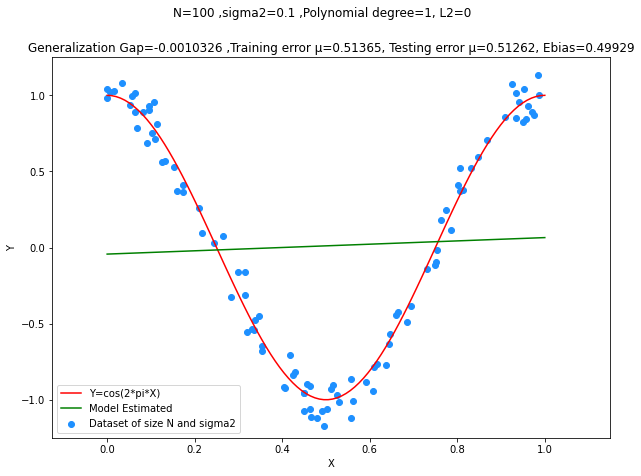

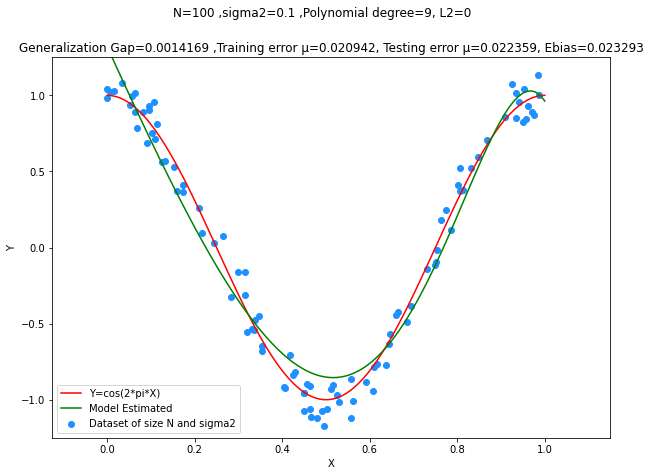

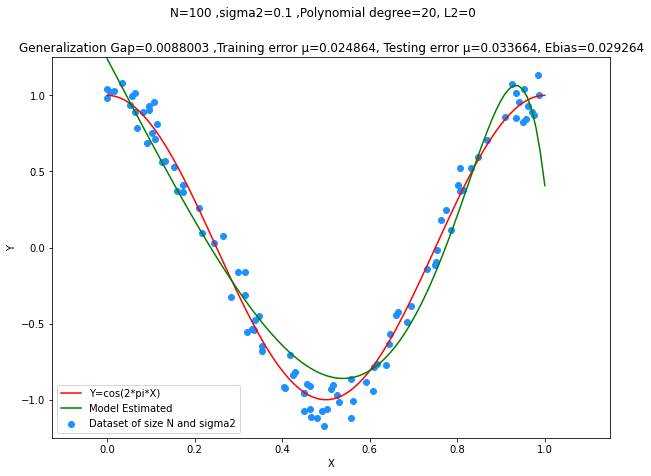

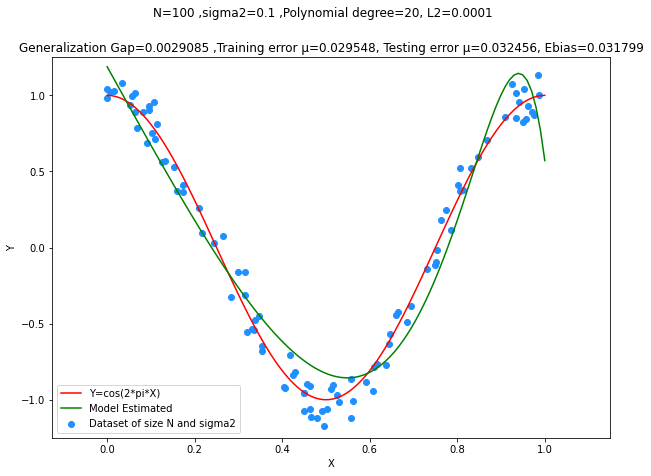

In [17]:

#datas from CSV files
rp20l=[0.029547584410425022,0.032456068772126756,0.03179865687094849]
p20l=[1.1879974565679867,-5.189355840542788,-0.020579739102394235,3.1532541336249675,2.4631985813835913,0.4027716157476819,0.1598724243321697,2.5627782913675756,0.6783423431515414,0.724930914760583,-1.64001331490167,-0.8052563739438565,-0.9762106613691592,-0.7718106215740522,-0.13649194668178882,-0.558772023287973,0.3514341257136804,-0.6507352090915188,-0.14135503043737702,0.05140481642954413,-0.2743409338129038]
rp1=[0.5136504460507553,0.5126178222246011,0.49928729999407095]
rp9=[0.02094238509129222,0.022359305764634553,0.023293451124658172]
rp20=[0.024864114854296803,0.03366437185393568,0.029263961898066446]

p1=[-0.043046394105101866,0.10837167076437353]
p9=[1.3199237757970477,-6.305880427310354,0.7910696910037431,4.846395874719771,1.9783459974378848,2.0015454892468365,0.08224921275840351,0.21516056133726572,-1.655770237467499,-2.3105207122308]
p20=[1.2402390136163537,-5.480241115363657,-0.0690765193690374,3.9910564581784556,1.6954069614061882,1.801969410429169,0.6206898817704982,1.0358112283097891,-0.1135843049905015,-0.428157694075745,-0.6409011792780819,-1.527403705271653,0.2691698610251344,0.5278078303346455,-1.1204422321403331,0.2430207923013678,-1.2033184875472005,0.2823431791883037,-0.792983284892769,0.25086559992448726,-0.1753845485313851]

results=[rp1,rp9,rp20,rp20l]
polynomialCoefficientsEstimated=[p1,p9,p20,p20l]

#######

P=PolynomialRegressionModel()
N=100
sigma2=0.1
polynomialDegree=[1,9,20,20]
dataset=P.getData(N,sigma2)
X=dataset[0]
Y=dataset[1]


myline = np.linspace(0, 1, 100)

plt.rcParams['figure.figsize'] = (10.0, 7.0)
L2=[0,0,0,0.0001]

for i in range(4):

    fig = plt.figure()
    Y_pred_eq = np.cos(2*np.pi*myline)
    Y_pred_model_estimated=P.polynomial(myline,polynomialCoefficientsEstimated[i], polynomialDegree[i])
    plt.suptitle("N="+str(N)+" ,sigma2="+str(sigma2) +" ,Polynomial degree="+str(polynomialDegree[i]) +", L2="+str(L2[i])) 
    plt.title("Generalization Gap="+str('%s' % float('%.5g' % (results[i][1]-results[i][0]))) +" ,Training error µ="+str('%s' % float('%.5g' % results[i][0])) +", Testing error µ="+str('%s' % float('%.5g' % results[i][1]))+", Ebias="+str('%s' % float('%.5g' % results[i][2])))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.scatter(X, Y, color='dodgerblue',label='Dataset of size N and sigma2') 
    plt.plot(myline, Y_pred_eq,color='red',label='Y=cos(2*pi*X)')
    plt.plot(myline, Y_pred_model_estimated,color='green',label='Model Estimated')#,marker='*') 
    plt.xlim(-0.125,1.15)
    plt.ylim(-1.25,1.25)
    plt.legend()
    plt.savefig('fe_'+str(N)+'_'+str(sigma2)+'_'+str(polynomialDegree[i])+'_L2'+ str(L2[i])+'.png') 
    
    


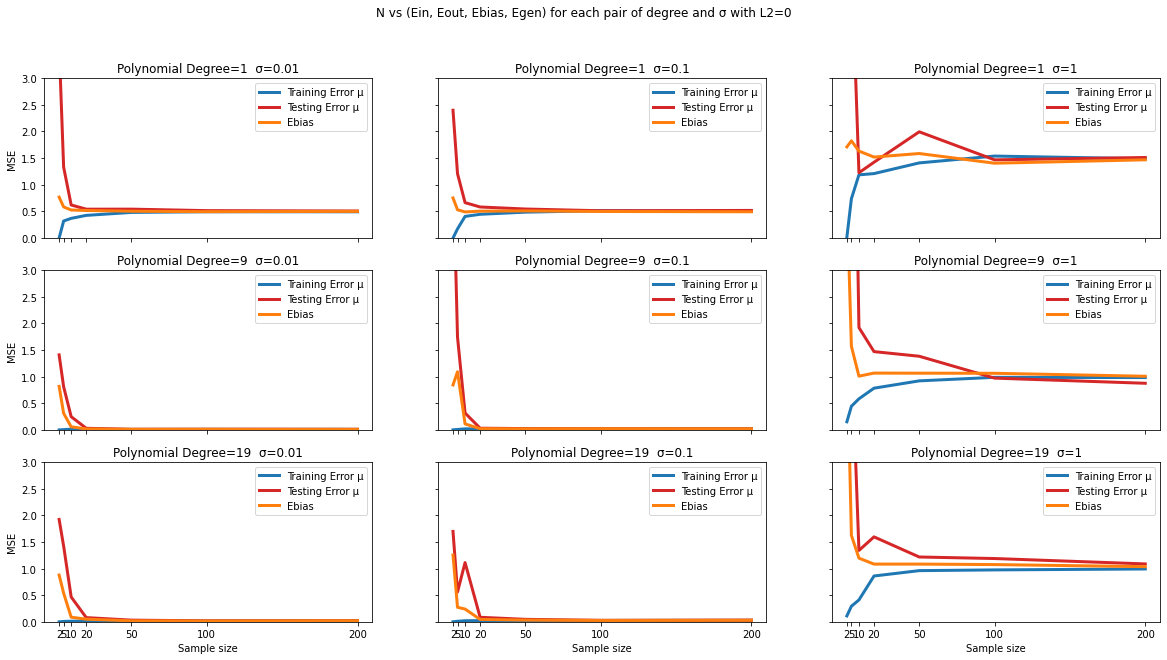

In [19]:

N=[2,5,10,20,50,100,200]
sigma2=[0.01,0.1,1]
pold=[1,9,19]

plt.rcParams['figure.figsize'] = (20.0, 10.0)     

fig, axDatasets = plt.subplots(3, 3)

fig.suptitle('N vs (Ein, Eout, Ebias, Egen) for each pair of degree and σ with L2=0')
    
for col in range(3):
    for row in range(3):
        
        d=dataset_general[dataset_general['polynomialDegree']==pold[row]]
        datasets1=d[d['sigma2']==sigma2[col]]

        axDatasets[row][col].plot( 'N', 'EinAveraged', label='Training Error µ' ,data=datasets1, marker='', color='tab:blue', linewidth=3)
        axDatasets[row][col].plot( 'N', 'EoutAveraged', label='Testing Error µ' ,data=datasets1, marker='', color='tab:red', linewidth=3)
        axDatasets[row][col].plot( 'N', 'Ebias',        data=datasets1, marker='', color='tab:orange', linewidth=3,)
        axDatasets[row][col].set_title("Polynomial Degree="+str(pold[row])+"  σ="+str(sigma2[col]) )
        axDatasets[row][col].set_xlabel("Sample size")
        axDatasets[row][col].set_ylabel("MSE")
        axDatasets[row][col].set_ylim(0,3)
        axDatasets[row][col].set_xticks(N)
        axDatasets[row][col].legend()
        
for ax in axDatasets.flat:
    ax.label_outer()    





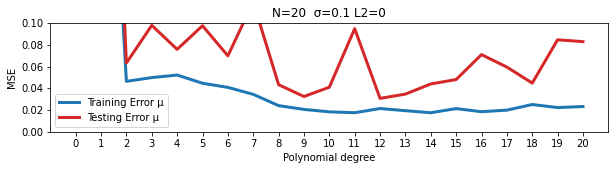

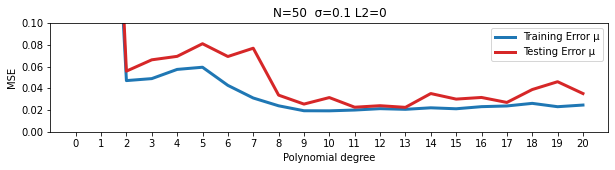

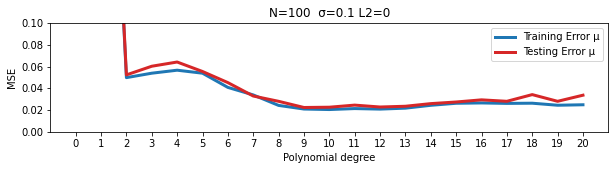

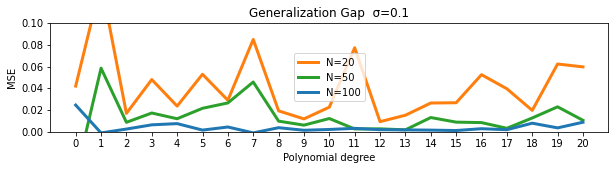

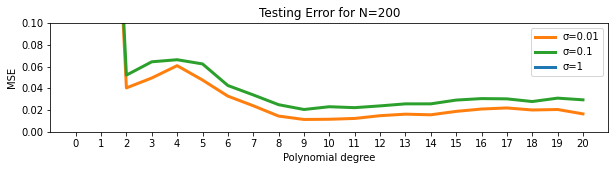

In [24]:


#PLOTS


datasets=[[dataset_2[dataset_2['sigma2']==0.01], dataset_5[dataset_5['sigma2']==0.01], dataset_10[dataset_10['sigma2']==0.01], dataset_20[dataset_20['sigma2']==0.01], dataset_50[dataset_50['sigma2']==0.01], dataset_100[dataset_100['sigma2']==0.01],dataset_200[dataset_200['sigma2']==0.01]],
          [dataset_2[dataset_2['sigma2']==0.1], dataset_5[dataset_5['sigma2']==0.1], dataset_10[dataset_10['sigma2']==0.1], dataset_20[dataset_20['sigma2']==0.1], dataset_50[dataset_50['sigma2']==0.1], dataset_100[dataset_100['sigma2']==0.1],dataset_200[dataset_200['sigma2']==0.1]],
          [dataset_2[dataset_2['sigma2']==1], dataset_5[dataset_5['sigma2']==1], dataset_10[dataset_10['sigma2']==1], dataset_20[dataset_20['sigma2']==1], dataset_50[dataset_50['sigma2']==1], dataset_100[dataset_100['sigma2']==1],dataset_200[dataset_200['sigma2']==1]]]
N=[2,5,10,20,50,100,200]
sigma2=[0.001,0.1,1]


plt.rcParams['figure.figsize'] = (10.0, 2.0) 

fig = plt.figure()
plt.plot( 'polynomialDegree', 'EinAveraged',  label='Training Error µ',data=datasets[1][3], marker='', color='tab:blue', linewidth=3)
plt.plot( 'polynomialDegree', 'EoutAveraged', label='Testing Error µ',data=datasets[1][3], marker='', color='tab:red', linewidth=3)
plt.title("N="+str(N[3])+"  σ="+str(sigma2[1])+" L2=0" )
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.ylim(0,0.1)
plt.xticks(range(21))
plt.legend()


fig = plt.figure()
plt.plot( 'polynomialDegree', 'EinAveraged', label='Training Error µ', data=datasets[1][4], marker='', color='tab:blue', linewidth=3)
plt.plot( 'polynomialDegree', 'EoutAveraged', label='Testing Error µ',data=datasets[1][4], marker='', color='tab:red', linewidth=3)
plt.title("N="+str(N[4])+"  σ="+str(sigma2[1])+" L2=0" )
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.ylim(0,0.1)
plt.xticks(range(21))
plt.legend()


fig = plt.figure()
plt.plot( 'polynomialDegree', 'EinAveraged', label='Training Error µ', data=datasets[1][5], marker='', color='tab:blue', linewidth=3)
plt.plot( 'polynomialDegree', 'EoutAveraged', label='Testing Error µ', data=datasets[1][5], marker='', color='tab:red', linewidth=3)
plt.title("N="+str(N[5])+"  σ="+str(sigma2[1])+" L2=0" )
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.xticks(range(21))
plt.ylim(0,0.1)
plt.legend()
        
fig = plt.figure()
plt.plot( 'polynomialDegree', 'Egen',label='N=20',        data=datasets[1][3], marker='', color='tab:orange', linewidth=3,)
plt.plot( 'polynomialDegree', 'Egen',label='N=50',         data=datasets[1][4], marker='', color='tab:green', linewidth=3)              
plt.plot( 'polynomialDegree', 'Egen',label='N=100',  data=datasets[1][5], marker='', color='tab:blue', linewidth=3)
plt.title("Generalization Gap  σ="+str(sigma2[1]) )
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.xticks(range(21))
plt.ylim(0,0.1)
plt.legend()
    
fig = plt.figure()
plt.plot( 'polynomialDegree', 'EoutAveraged',label='σ=0.01',        data=datasets[0][6], marker='', color='tab:orange', linewidth=3,)
plt.plot( 'polynomialDegree', 'EoutAveraged',label='σ=0.1',         data=datasets[1][6], marker='', color='tab:green', linewidth=3)              
plt.plot( 'polynomialDegree', 'EoutAveraged',label='σ=1',  data=datasets[2][6], marker='', color='tab:blue', linewidth=3)
plt.title("Testing Error for N="+str(200) )
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.xticks(range(21))
plt.ylim(0,0.1)
plt.legend()     
    





